# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[num_test/2:], newsgroups_test.target[num_test/2:]
dev_data, dev_labels = newsgroups_test.data[:num_test/2], newsgroups_test.target[:num_test/2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print 'training label shape:', train_labels.shape
print 'test label shape:', test_labels.shape
print 'dev label shape:', dev_labels.shape
print 'labels names:', newsgroups_train.target_names

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

In [3]:
def P1(num_examples=5):
### STUDENT START ###
    for i in range(num_examples):
        print "\nEaxmple %i,  Label: %s" % (i+1, train_labels[i])
        print "Text: \n%s" % train_data[i]

### STUDENT END ###
P1()


Eaxmple 1,  Label: 1
Text: 
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych

Eaxmple 2,  Label: 3
Text: 


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.

Ea

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

In [4]:
def P2():
### STUDENT START ###

    # (a.) Turn the raw training text into feature vectors
    count_vect = CountVectorizer()
    cvf = count_vect.fit(train_data)
    X_train = cvf.transform(train_data)
    X_dev = cvf.transform(dev_data)
    
    # Size of the vocabulary
    [num_examples, num_features] = X_train.shape
    print "(a)"
    print "Size of Vocabulary: %i" % num_features
    # The average number of non-zero features per example
    print "Average number of non-zero features per example %2.1f%%" % ((len(X_train.getnnz(1)) / float(num_features))*100)
    # The fraction of the entries in the matrix are non-zero
    print "The fraction of non-zero entries in the matrix: %i/%i (%2.1f%%)" % (X_train.nnz, float(num_features * num_examples), 
                                                                             ((X_train.nnz / float(num_features * num_examples))*100))
    
    # (b.) Print the 0th and last feature strings (in alphabetical order). 
    print "\n(b)"
    print "Feature Strings: "
    print "\tFirst: %s" % count_vect.get_feature_names()[0]
    print "\tLast:  %s" % count_vect.get_feature_names()[-1]
    feature_names = cvf.get_feature_names()
    
    # (c.) Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. 
    my_vocab = ['atheism', 'graphics', 'space', 'religion']
    cv_vocab = CountVectorizer(vocabulary=my_vocab)
    X_train_vocab = cv_vocab.fit_transform(train_data)
    [l, w] = X_train_vocab.shape
    print "\n(c)"
    print "Specifing Vocab List:"
    print my_vocab
    print "Size of Vocabulary with specified vocab list: %i " % w
    print "Average number of non-zero features per example %2.1f" % (X_train_vocab.nnz / float(l))


    # (d.) Extract Bigram and Trigram Character features 
    bigram_vectorizer = CountVectorizer(ngram_range=(2, 3))
    analyze = bigram_vectorizer.build_analyzer()
    X_train_bigram = bigram_vectorizer.fit_transform(train_data)
    [l, w] = X_train_bigram.shape
    print "\n(d)"
    print "Size of Bigram and trigram Vocabulary: %i" % w
    feat_names_bigram = bigram_vectorizer.get_feature_names()
    

    # (e.) Prune for words that appear in fewer than 10 documents
    bigram_vectorizer = CountVectorizer(ngram_range=(2, 3), min_df = 10)
    analyze = bigram_vectorizer.build_analyzer()
    X_train_bigram_pruned = bigram_vectorizer.fit_transform(train_data)
    [l, w] = X_train_bigram_pruned.shape
    print "\n(e)"
    print "Size of Bigram and trigram Vocabulary After Pruning: %i" % w
    

    # (f.) Determine Words from Dev not in Train 
    train_vocab = count_vect.vocabulary_.keys()
    cv_dev = CountVectorizer()
    X_dev2 = cv_dev.fit_transform(dev_data)
    dev_vocab = cv_dev.vocabulary_.keys()
    yes, no = 0, 0
    for word in dev_vocab:
        if word not in train_vocab:
            no += 1
        else: 
            yes += 1
    print "\n(f)"
    print "%i/%i (%1.2f) Words in Dev Vocab are not in Train Vocab" % (no, len(dev_vocab) ,no / float(len(dev_vocab)))

    return X_train, feature_names, X_train_bigram, feat_names_bigram, X_dev
### STUDENT END ###
[X_train, feature_names, X_train_bigram, feat_names_bigram, X_dev] = P2()

(a)
Size of Vocabulary: 26879
Average number of non-zero features per example 7.6%
The fraction of non-zero entries in the matrix: 196700/54671886 (0.4%)

(b)
Feature Strings: 
	First: 00
	Last:  zyxel

(c)
Specifing Vocab List:
['atheism', 'graphics', 'space', 'religion']
Size of Vocabulary with specified vocab list: 4 
Average number of non-zero features per example 0.3

(d)
Size of Bigram and trigram Vocabulary: 510583

(e)
Size of Bigram and trigram Vocabulary After Pruning: 3381

(f)
4027/16246 (0.25) Words in Dev Vocab are not in Train Vocab


(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.


In [5]:
# Defining Function to fit models with specific parameters to avoid duplicating code
# Used in P3
def fit_model(model_name, search_grid, score, train_df, train_labels):
    model = model_name()
    param_searcher = GridSearchCV(model, search_grid, cv=10, scoring=score)
    param_searcher.fit(train_df, train_labels)
    return param_searcher

In [6]:
# Defining function to plot grid scores
def plot_grid_scores(x,y,x_label,y_label,title):
    plt.plot(x, y, '.')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()
    return plt

/usr/local/lib/python2.7/site-packages/sklearn/neighbors/base.py:378: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  neigh_ind = neigh_ind[:, :n_neighbors]


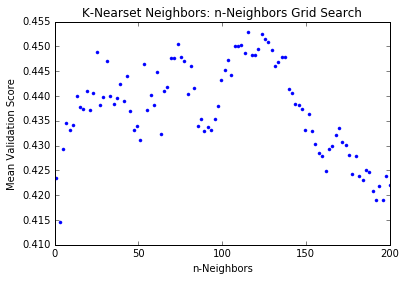

/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


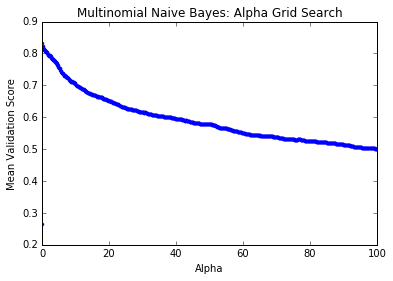

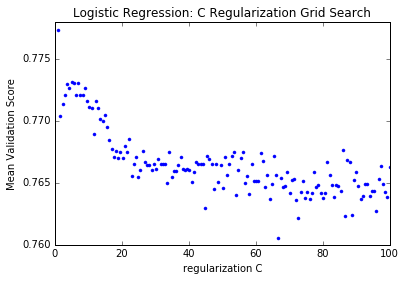

K-Nearest Neighbors
	Optimal k = 115
	Best f1_weighted Score: 0.453

Multinomial Naive Bayes
	Optimal alpha = 0.1001
	Best f1_weighted Score: 0.832

Logistic Regression
	Optimal C = 1.00000
	Best f1_weighted Score: 0.777


Sum of Squares by class for each setting of C paramater
C Param  |    alt.atheism |   talk.religion.misc |  comp.graphics |      sci.space |
0.0100    |   2.541531  |   2.939709  |   2.862466  |   2.250029  |
0.1000    |  27.129109  |  24.658559  |  27.459275  |  23.025848  |
1.0000    | 166.991625  | 130.908382  | 157.997486  | 145.735657  |
10.0000    | 586.455101  | 449.074264  | 539.307673  | 530.746985  |
100.0000    | 1400.496748  | 1098.006891  | 1289.200263  | 1314.797513  |
1000.0000    | 2702.853236  | 1939.794408  | 2381.455481  | 2472.230672  |


In [7]:
def P3(score, neighbors, alphas, regularization_cs):
### STUDENT START ###

    # Fit Models and Calculate scores

    # k-NN
    knn = fit_model(KNeighborsClassifier, neighbors, score, X_train, train_labels)
    grid_scores = pd.DataFrame(knn.grid_scores_)
    grid_scores['n_neighbors'] = pd.Series(neighbors['n_neighbors'])
    plot_grid_scores(grid_scores['n_neighbors'],grid_scores['mean_validation_score'], "n-Neighbors", 
                     "Mean Validation Score","K-Nearset Neighbors: n-Neighbors Grid Search")
    
    # Multinomial Naive Bayes
    mnb = fit_model(MultinomialNB, alphas, score, X_train, train_labels)
    grid_scores = pd.DataFrame(mnb.grid_scores_)
    grid_scores['alpha'] = pd.Series(alphas['alpha'])
    plot_grid_scores(grid_scores['alpha'],grid_scores['mean_validation_score'], "Alpha", 
                     "Mean Validation Score","Multinomial Naive Bayes: Alpha Grid Search")
    
    # Logistic Regression 
    lr = fit_model(LogisticRegression, regularization_Cs, score, X_train, train_labels)
    grid_scores = pd.DataFrame(lr.grid_scores_)
    grid_scores['C'] = pd.Series(regularization_Cs['C'])
    plot_grid_scores(grid_scores['C'],grid_scores['mean_validation_score'], "regularization C", 
                     "Mean Validation Score","Logistic Regression: C Regularization Grid Search")
    
    # Report Results
    print "K-Nearest Neighbors"
    print "\tOptimal k = %i" % knn.best_params_.get('n_neighbors')
    print "\tBest %s Score: %0.3f" % (score, knn.best_score_)
    
    print "\nMultinomial Naive Bayes"
    print "\tOptimal alpha = %1.4f" % mnb.best_params_.get('alpha')
    print "\tBest %s Score: %0.3f" % (score, mnb.best_score_)
    
    print "\nLogistic Regression"
    print "\tOptimal C = %3.5f" % lr.best_params_.get('C')
    print "\tBest %s Score: %0.3f" % (score, lr.best_score_)

    # P3 Continued, part C
    # Output the sum of the squared weight values for each class for each setting of the C parameter. 
    C_params = [0.01, 0.1, 1, 10, 100, 1000]
    sum_of_squares_all = []
    # features by adjusting the C parameter
    for c in C_params:
        lr_c = LogisticRegression(C=c, penalty="l2")
        lr_c.fit(X_train, train_labels)
        sum_of_squares = [c, sum(np.square(lr_c.coef_[0])), sum(np.square(lr_c.coef_[1])), 
                      sum(np.square(lr_c.coef_[2])), sum(np.square(lr_c.coef_[3]))]
        sum_of_squares_all.append(sum_of_squares)

    print "\n\nSum of Squares by class for each setting of C paramater"
    print "C Param  | %14s | %20s | %14s | %14s |" % (categories[0], categories[1], categories[2], categories[3])
    for i in range(len(sum_of_squares_all)):
        print "%4.4f    | %10f  | %10f  | %10f  | %10f  |" %(sum_of_squares_all[i][0], sum_of_squares_all[i][1], 
                                       sum_of_squares_all[i][2], sum_of_squares_all[i][3], sum_of_squares_all[i][4])

    
    return lr 

# Set model initilaization parameters
score = 'f1_weighted'
neighbors = {'n_neighbors': np.linspace(1, 200, 100, endpoint=True)}
alphas = {'alpha': np.linspace(0, 100, 1000, endpoint=True)}
regularization_Cs = {'C': np.linspace(1, 100, 150, endpoint=True), 'penalty': ['l2']}

### STUDENT END ###
lr = P3(score, neighbors, alphas, regularization_Cs)
lr_best_params = lr.best_params_


ANSWER:

a. Why doesn't nearest neighbors work well for this problem? 

K-NN does not work well for this problem because the training data is a sparse matrix which creates a dimensionality issue. The data is very wide - with many more features than training examples. For any given datapoint, the "nearest neighbor" is hard to find because all other datapoints begins to look at a very similar distance and they become indistinguishable in high dimentions. Therefore, it is hard to decipher which point is most similar to the one in question. The next nearest may not actually be the most relevant and therefore clusters are not reliable. 


b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

Naive Bayes relies on conditional probbaility weights that are updated throughout training. As certain words are learned to be good indicators of a topic (such as a religious word vs. a computer graphics word) and when the word is not likely be used in both contexts - the weight of that word becomes very idicitive of the topic. In other words, the probability that the specific work indicates a topic becomes very high and influences the classifictaion more than words that are seen less often or used across many subject matters. 

Logistic regression generally is good for more binary classification. Logistic regression looks for correlation among the dependent and independent varaiables and also has a lot of strong assumptions. The output gives a likelihood function that the text sample belongs to each of the possible targets - and the maximum is chosen as the prediction. 
The features here depends greatly on preprocesing and feature normalization before training. How this process is completed can have an effect on the accuracy. 


c. Logistic regression estimates a weight vector for each class, which you can access with the coef_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C. 

The sum of squared weight values for each class increase as the value of C increases.


(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

In [17]:
def P4(feature_names, lr_best_params, regularization_Cs):
### STUDENT START ###
    
    # Train Model For Original Model
    lr = LogisticRegression(C=lr_best_params.get('C'), penalty=lr_best_params.get('penalty'))
    lr.fit(X_train, train_labels)
    
    # Print Weights and Features for each Category Label
    print "Original Features with highest weights for each label"
    print "Index  |  Feature Name        | %18s | %19s | %18s | %15s |" % (categories[0], categories[1], categories[2], categories[3])
    for i in range(lr.coef_.shape[0]):
        idx = np.argsort(np.abs(lr.coef_[i]))[0:5]
        for j in idx:
            print "%6i | %20s | %18s | %19s | %18s | %15s |" % (j, feature_names[j], lr.coef_[0,j], lr.coef_[1,j], lr.coef_[2,j], lr.coef_[3,j])

            
    # Train Model For Bigram Features Model
    # Grid Search for best regularization C parameter 
    lr = LogisticRegression()
    param_searcher = GridSearchCV(lr, regularization_Cs, cv=10, scoring=score)
    param_searcher.fit(X_train_bigram, train_labels)
    lrbigram_best_params = param_searcher.best_params_
    
    lr_bigram = LogisticRegression(C=lrbigram_best_params.get('C'), penalty=lrbigram_best_params.get('penalty'))
    lr_bigram.fit(X_train_bigram, train_labels)
    
    # Print Weights and Features for each Category Label
    print "\n\nBigram Features with highest weights for each label"
    print "Index  |  Feature Name        | %18s | %19s | %18s | %15s |" % (categories[0], categories[1], categories[2], categories[3])
    for i in range(lr_bigram.coef_.shape[0]):
        idx = np.argsort(np.abs(lr_bigram.coef_[i]))[0:5]
        for j in idx:
            print "%6i | %20s | %18s | %19s | %18s | %15s |" % (j, feat_names_bigram[j], lr_bigram.coef_[0,j], lr_bigram.coef_[1,j], lr_bigram.coef_[2,j], lr_bigram.coef_[3,j])
    
### STUDENT END ###
regularization_Cs = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l2']}
P4(feature_names, lr_best_params, regularization_Cs)

Original Features with highest weights for each label
Index  |  Feature Name        |        alt.atheism |  talk.religion.misc |      comp.graphics |       sci.space |
 17376 |                  oed | -5.80296171209e-09 |   2.66618691247e-05 |   1.8145407176e-05 | -2.70139471871e-05 |
  4085 |                  axe | -5.80296171209e-09 |   2.66618691247e-05 |   1.8145407176e-05 | -2.70139471871e-05 |
 18299 |             perjurer | -5.80296171209e-09 |   2.66618691247e-05 |   1.8145407176e-05 | -2.70139471871e-05 |
 20543 |            rephrased | -5.80296171209e-09 |   2.66618691247e-05 |   1.8145407176e-05 | -2.70139471871e-05 |
 22660 |           specifying | -5.80296171209e-09 |   2.66618691247e-05 |   1.8145407176e-05 | -2.70139471871e-05 |
 10462 |               fitted |  -0.00765021711194 |   1.10159458579e-09 |  1.41210381115e-05 | 7.16274903227e-06 |
 17995 |            parallels |  -0.00260470666119 |   -1.1577801793e-08 | -1.04796380186e-05 | 0.00213403225992 |
 24498 |        

ANSWER:

Any surprising features in this table?

Yes, many. For the single words, some features are numbers or words that are not actually words ("oed"), and some still have characters in the feature "_wants_"

For the ngram features some make more sense but there are still that appear to be overlapping features. For example: "God as described" and "as described by". 


(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.


Size of Vocabulary after No Preprocess: 2034 X 33291

Use Preprocessor

Size of Vocabulary after preprocessor: 2034 X 22906

Results for No preprocessor
	Optimal C = 1.00000
	Best f1_weighted Score: 0.776
	Predicted Score on Dev Data 0.71

Results with Preproccessor
	Optimal C = 1.00000
	Best f1_weighted Score: 0.777
	Predicted Score on Dev Data 0.69


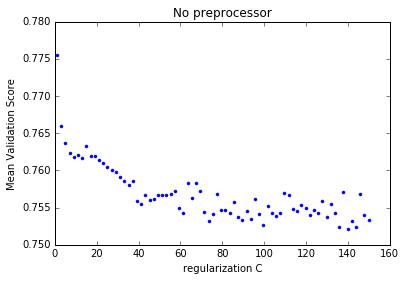

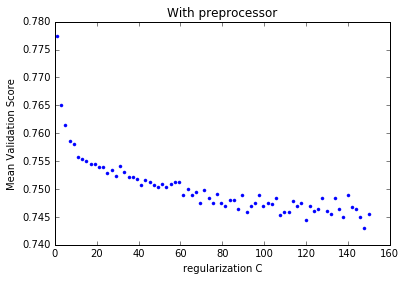

In [10]:
def empty_preprocessor(s):
    return s

def better_preprocessor(s):
### STUDENT START ###
    
    # Lower case all words
    s = s.lower()
    
    # remove punctuation and special characters 
    char = ['.',',',':',';','-','?','!','@','#','$','(',')','/','"', '\'', '_', '+', '=','%','^']
    for c in char:
        s = s.replace(c, '')
    
    # replace numbers with "xx" 
    s = re.sub('\d', 'digit', s)
    s = re.sub('.+>', ' ', s)
    s = re.sub('\dth', 'date ', s)
    s = re.sub('&', 'and ', s)
    
    # remove common words 
    common_words = ['a','about','above','after','again','against','all','am',
                    'an','and','any','are','arent','as','at','be','because','been','before','being',
                    'below','between','both','but','by','cant','cannot','could','couldnt','did','didnt','do',
                    'does','doesnt','doing','dont','down','during','each','few','for','from','further','had',
                    'hadnt','has','hasnt','have','havent','having','he','hed','hell','hes','her','here','heres',
                    'hers','herself','him','himself','his','how','hows','i','id','ill','im','ive','if','in','into',
                    'is','isnt','it','its','itself','lets','me','more','most','mustnt','my','myself','no','nor','not',
                    'of','off','on','once','only','or','other','ought','our','ours','ourselves','out','over','own',
                    'same','shant','she','shed','shell','shes','should','shouldnt','so','some','such','than','that',
                    'thats','the','their','theirs','them','themselves','then','there','theres','these','they','theyd',
                    'theyll','theyre','theyve','this','those','through','to','too','under','until','up','very',
                    'was','wasnt','we','wed','well','were','weve','werent','what','whats','when','whens','where',
                    'wheres','which','while','who','whos','whom','why','whys','with','wont',
                    'would','wouldnt','you','youd','youll','youre','youve','your','yours','yourself','yourselves']
    for c in common_words:
        s = s.replace(c, '')
        
    
    return s

### STUDENT END ###


def P5():
### STUDENT START ###

    # Search for best params 
    score = 'f1_weighted'
    regularization_Cs = {'C': np.linspace(1, 150, 75, endpoint=True), 'penalty': ['l2']}
    
    # Calculate Best Logistic Regression model without preprocessing 
    count_vect_none = CountVectorizer(preprocessor = empty_preprocessor)
    cvf_none = count_vect_none.fit(train_data)
    X_train_none = cvf_none.transform(train_data)
    X_dev_none = cvf_none.transform(dev_data)
    print "\nSize of Vocabulary after No Preprocess: %i X %i" % (X_train_none.shape[0], X_train_none.shape[1])
    # Grid Search for Best Params 
    lr_none_gs = fit_model(LogisticRegression, regularization_Cs, score, X_train_none, train_labels)
    grid_scores_none = pd.DataFrame(lr_none_gs.grid_scores_)
    grid_scores_none['C'] = pd.Series(regularization_Cs['C'])
    # Fit best model 
    lr_none = LogisticRegression(C=lr_none_gs.best_params_.get('C'), penalty="l1")
    lr_none.fit(X_train_none, train_labels)
    
    
    # With Preprocessing The Feature Set
    print "\nUse Preprocessor"
    count_vect_prep = CountVectorizer(preprocessor = better_preprocessor)
    cvf = count_vect_prep.fit(train_data)
    X_train_prep = cvf.transform(train_data)
    X_dev_prep = cvf.transform(dev_data)
    print "\nSize of Vocabulary after preprocessor: %i X %i" % (X_train_prep.shape[0], X_train_prep.shape[1])
    # Grid Search for best Params 
    lr_pre_gs = fit_model(LogisticRegression, regularization_Cs, score, X_train_prep, train_labels)
    grid_scores_prep = pd.DataFrame(lr_pre_gs.grid_scores_)
    grid_scores_prep['C'] = pd.Series(regularization_Cs['C'])
    # Fit best model 
    lr_pre = LogisticRegression(C=lr_pre_gs.best_params_.get('C'), penalty="l1")
    lr_pre.fit(X_train_prep, train_labels)
    
    
    # Report Results for both models
    print "\nResults for No preprocessor"
    print "\tOptimal C = %3.5f" % lr_none_gs.best_params_.get('C')
    print "\tBest %s Score: %0.3f" % (score, lr_none_gs.best_score_)
    print "\tPredicted Score on Dev Data %0.2f" % lr_none.score(X_dev_none, dev_labels)
    
    
    print "\nResults with Preproccessor"
    print "\tOptimal C = %3.5f" % lr_pre_gs.best_params_.get('C')
    print "\tBest %s Score: %0.3f" % (score, lr_pre_gs.best_score_)
    print "\tPredicted Score on Dev Data %0.2f" % lr_pre.score(X_dev_prep, dev_labels)
    
    
    # Plots 
    plot_grid_scores(grid_scores_none['C'],grid_scores_none['mean_validation_score'], "regularization C", 
                     "Mean Validation Score","No preprocessor")
    plot_grid_scores(grid_scores_prep['C'],grid_scores_prep['mean_validation_score'], "regularization C", 
                     "Mean Validation Score","With preprocessor")
    
### STUDENT END ###
P5()

(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

In [11]:
# Defining function to ouput accuracy of re-trained model and vocaulary of the model by adjusting the C parameter
def vocab_adjustment(C_params, X_train, train_labels, X_dev, dev_labels):
    # features by adjusting the C parameter
    vocab_size = []
    accuracy = []
    for c in C_params:
        lr_c = LogisticRegression(C=c, penalty="l1", tol=0.01)
        lr_c.fit(X_train, train_labels)
        coefs = lr_c.coef_
        non_zero_index = []
        for i in range(coefs.shape[1]):
            if sum(coefs[:,i]) > 0:
                non_zero_index.append(i)
        vocab_size.append(len(non_zero_index))
    
        # Keeping only Featues that have at least one non-zero weight 
        X_train_reduce = X_train[:,non_zero_index]
        # feature_names_reduce = np.asarray(feature_names)[non_zero_index]
        X_dev_reduce = X_dev[:,non_zero_index]
    
        # Retrain Logistic Regression with penalty = "l2"
        lr_c_l2 = LogisticRegression(C=c, penalty="l2")
        lr_c_l2.fit(X_train_reduce, train_labels)
        accuracy.append(lr_c_l2.score(X_dev_reduce, dev_labels))
    
    return vocab_size, accuracy

Searching for best Logistic Regression parameters with pnealty 'l1'
	Best Score for penalty l1 trained model: 0.782
	Best C parameter 3.48743718593


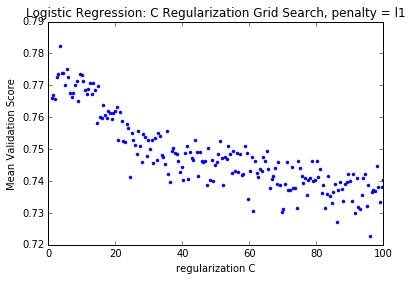

Fit model with penalty = l1 with optimal C value 3.4874
	Predicted Score on Dev Data 0.68

Number or learned weights not equal to zero 915 of 26879

How does this compare to the number of non-zero weights you get with "l2"?
There are many more non-zero weights with l2 than with l1.
	Removing features with zero weights. 
	Shape of training features now: 2034 X 915

Search for Optical C value with penalty = l2 and reduced feature space


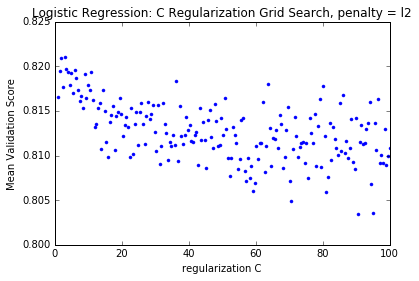


Fit model with penalty = l2 on Reduced Features. Optimal C value 2.9899
	Predicted Score on Dev Data 0.65


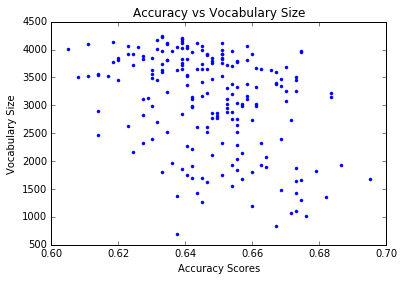

In [12]:
def P6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    ### STUDENT START ###
    C_params = np.linspace(1, 100, 200, endpoint=True)
    # C_params = np.linspace(1, 10, 5, endpoint=True)
    # Search for best C to use with penalty l1
    print "Searching for best Logistic Regression parameters with pnealty 'l1'"
    regularization_Cs = {'C': C_params, 'penalty': ['l1'], 'tol' : [0.01]}
    score = 'f1_weighted'
    lr_gs = fit_model(LogisticRegression, regularization_Cs, score, X_train, train_labels)
    print "\tBest Score for penalty l1 trained model: %0.3f" % lr_gs.best_score_
    print "\tBest C parameter %s" % lr_gs.best_params_.get('C')
    
    # Visualize search parameters and validation scores
    grid_scores = pd.DataFrame(lr_gs.grid_scores_)
    grid_scores['C'] = pd.Series(regularization_Cs['C'])
    plot_grid_scores(grid_scores['C'],grid_scores['mean_validation_score'], "regularization C", 
                     "Mean Validation Score","Logistic Regression: C Regularization Grid Search, penalty = l1")

    
    # Fit with all features and penalty = l1 using C found above
    print "Fit model with penalty = l1 with optimal C value %1.4f" % lr_gs.best_params_.get('C')
    lr_l1 = LogisticRegression(C=lr_gs.best_params_.get('C'), penalty="l1")
    lr_l1.fit(X_train, train_labels)
    print "\tPredicted Score on Dev Data %0.2f" % lr_l1.score(X_dev, dev_labels)
    
    # Output the number of learned weights that are not equal to zero
    coefs = lr_l1.coef_
    non_zero_index = []
    for i in range(coefs.shape[1]):
        if sum(coefs[:,i]) > 0:
            non_zero_index.append(i)
    print "\nNumber or learned weights not equal to zero %i of %i" % (len(non_zero_index), coefs.shape[1])

    print "\nHow does this compare to the number of non-zero weights you get with \"l2\"?"
    print "There are many more non-zero weights with l2 than with l1."

    # Keeping only Featues that have at least one non-zero weight 
    X_train_reduce = X_train[:,non_zero_index]
    feature_names_reduce = np.asarray(feature_names)[non_zero_index]
    X_dev_reduce = X_dev[:,non_zero_index]
    print "\tRemoving features with zero weights. \n\tShape of training features now: %i X %i" % (X_train_reduce.shape[0], X_train_reduce.shape[1])
    
    # Retrain Logistic Regression with penalty = "l2"
    regularization_Cs = {'C': C_params, 'penalty': ['l2'], 'tol' : [0.01]}
    lr_l2_gs = fit_model(LogisticRegression, regularization_Cs, score, X_train_reduce, train_labels)
    
    print "\nSearch for Optical C value with penalty = l2 and reduced feature space"
    grid_scores = pd.DataFrame(lr_l2_gs.grid_scores_)
    grid_scores['C'] = pd.Series(regularization_Cs['C'])
    plot_grid_scores(grid_scores['C'],grid_scores['mean_validation_score'], "regularization C", 
                     "Mean Validation Score","Logistic Regression: C Regularization Grid Search, penalty = l2")
    
    print "\nFit model with penalty = l2 on Reduced Features. Optimal C value %1.4f" % lr_l2_gs.best_params_.get('C')
    lr_l2 = LogisticRegression(C=lr_l2_gs.best_params_.get('C'), penalty="l2")
    lr_l2.fit(X_train_reduce, train_labels)
    print "\tPredicted Score on Dev Data %0.2f" % lr_l2.score(X_dev_reduce, dev_labels)
    
    # features by adjusting the C parameter
    [vocab_size, accuracy] = vocab_adjustment(C_params, X_train, train_labels, X_dev, dev_labels)
    # Plot Accuracy vs. Vocab Size
    plot_grid_scores(accuracy,vocab_size,"Accuracy Scores","Vocabulary Size","Accuracy vs Vocabulary Size")

    
    ### STUDENT END ###
P6()



(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

In [13]:
def P7():
### STUDENT START ###
    vectorizer = TfidfVectorizer()
    v_fit = vectorizer.fit(train_data)
    X_train_tfidf = v_fit.transform(train_data)
    X_dev_tfidf = v_fit.transform(dev_data)
    
    print "\nSize of Train Vocabulary with tfidf vectorizer: %i X %i" %(X_train_tfidf.shape[0], X_train_tfidf.shape[1])
    print "Size of Development Vocabulary with tfidf vectorizer: %i X %i" %(X_dev_tfidf.shape[0], X_dev_tfidf.shape[1])
    
    # Train Logistic Regression with C = 100
    lr = LogisticRegression(C=100)
    lr.fit(X_train_tfidf, train_labels)
    # Make predictions on Dev Data 
    print "\nLogistic Regression predictions on Dev Data %0.2f" % lr.score(X_dev_tfidf, dev_labels)
    
    # Show top 3 documents where ratio R is largest 
    predicted = []
    for j in range(len(dev_labels)):
        p = lr.predict_proba(X_dev_tfidf)[j,dev_labels[j]]
        predicted.append(p)
        
    # maximum predicted probability / predicted probability of the correct label   
    R = np.apply_along_axis(max, 1, lr.predict_proba(X_dev_tfidf)) / predicted
    idx = R.argsort()[-3:][::-1]
    c = 0
    print"\nTop 3 Documents where ratio R is largest"
    for j in idx:
        c += 1
        print "\nDocument Text %i" % c
        print "\tR = %3.3f, idx=%i, Text:\n" %(R[j], j)
        print dev_data[j]

## STUDENT END ###
P7()


Size of Train Vocabulary with tfidf vectorizer: 2034 X 26879
Size of Development Vocabulary with tfidf vectorizer: 676 X 26879

Logistic Regression predictions on Dev Data 0.76

Top 3 Documents where ratio R is largest

Document Text 1
	R = 929.344, idx=215, Text:

I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can 

ANSWER:

Use the TfidfVectorizer -- how is this different from the CountVectorizer?

CountVectorizer just counts the word frequencies of appearences in teh text documents/examples. 
Where as TfidfVectorizer looks at term frequency (tf) and inverse document frequency (idf). This means that if a specific phrase appears a lot of times in a given document, but it doesn’t appear in many other documents, then it could be a good indicator of what the document is about and could be important in distinguishing that document from all the others. Tfidf does not use all words - removes really common and overlapping words from the fetaure set that would not indicate any meaning on their own and keeps words that are more unique among the documents. 

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

The model seems to be mistaking any religious word with being a religous affiliated document. For these three examples above, all have referneces to "The Book of Morman" which could be a refernce to the sacred text of Latter Day Saints or in refernec to the musical. It is putting too much emphasis on singular words. One suggetsion could be to include phases and bigram and trigram features to add more context to the data. 



(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.